In [1]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

mi.variants()

['scalar_rgb', 'scalar_spectral', 'cuda_ad_rgb', 'llvm_ad_rgb']

In [2]:
mi.set_variant("cuda_ad_rgb")

In [3]:
def reset_scene():
    return mi.load_file("../scenes/cbox.xml", res=128, integrator="prb")

In [4]:
scene_ref = reset_scene()
image_ref = mi.render(scene_ref, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [5]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

def to_float(x):
    # hacky way to convert Mitsuba float to Python float
    return float(np.array(x))

# 1d parameterized loss landscape

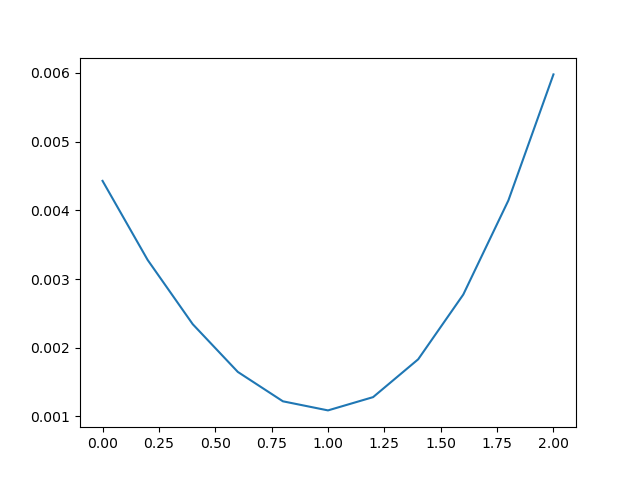

In [6]:
key = 'red.reflectance.value'

X = dr.linspace(mi.Float, 0.0, 2.0, 11)
Y = []
for x in X:
    scene = reset_scene()
    params = mi.traverse(scene)
    params[key] *= x
    image = mi.render(scene, spp=128)
    Y.append(mse(image))

fig, ax = plt.subplots()
ax.plot(X, Y);

# 2D parameterized loss landscape

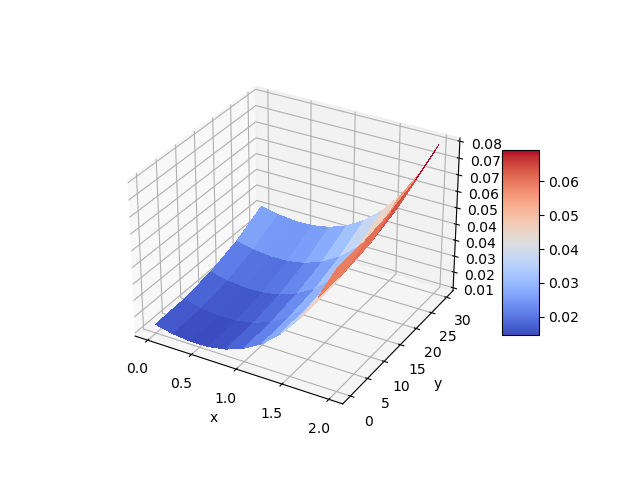

In [7]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
key = 'red.reflectance.value'

# Make data.
X = np.linspace(0.0, 2.0, 11)
Y = np.linspace(0.0, 30.0, 5)
X, Y = np.meshgrid(X, Y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        scene = reset_scene()
        params = mi.traverse(scene)
        params[key] = mi.Color3f(X[i, j], Y[i, j] * params[key].y, Y[i, j] * params[key].z)
        image = mi.render(scene, spp=8)
        Z[i, j] = to_float(mse(image))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
# Customize the z axis.
ax.set_zlim(np.min(Z), np.max(Z))
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5);

# Optimization

In [8]:
scene = reset_scene()
params = mi.traverse(scene)

key = 'red.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])

opt = mi.ad.Adam(lr=0.02)

# Our latent variable
opt_key = "theta"
opt[opt_key] = mi.Float(0.1)

# The wall color now depends on `theta`
def update_scene():
    params[key] = dr.clamp(param_ref * opt[opt_key], 0.0, 1.0)
    params.update()

update_scene()

In [9]:
image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [10]:
iteration_count = 100
errors = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Update the scene state to the new optimized values
    update_scene()

    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

Iteration 99: parameter error = 0.000050
Optimization complete.


In [11]:
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

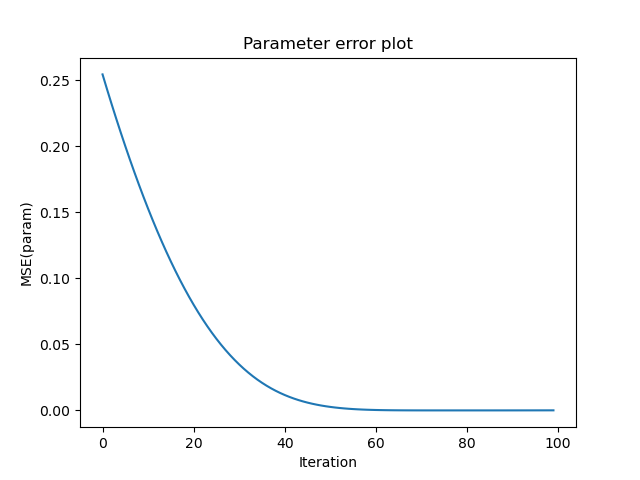

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE(param)')
ax.set_title('Parameter error plot')
ax.plot(errors)

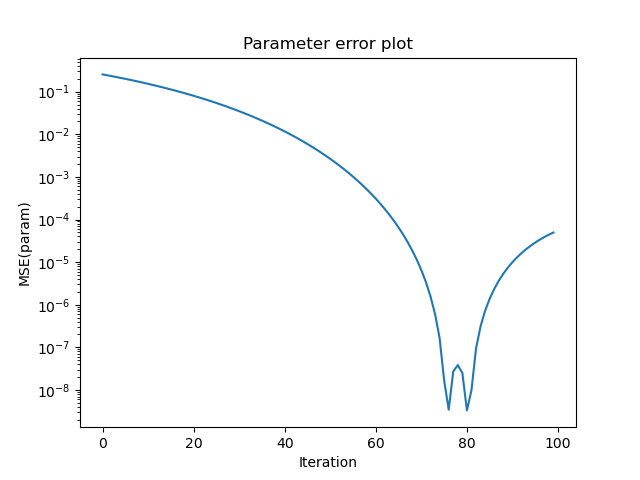

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE(param)')
ax.set_title('Parameter error plot')
ax.semilogy(errors)